In [1]:
from gurobipy import *
from passenger import *
import pandas as pd

import matplotlib.pyplot as plt
import itertools
import random

In [2]:
# Load Passengers

df = read_and_preprocess('DataSeating - V3.xlsx', '21Oct')

groups = get_list_passengers(df)

passengers = list()

for g in groups.keys():
    passengers += groups[g].members

In [3]:

passengers_count = len(passengers)

width = 6
height = 28
X = [-3, -2, -1, 0, 1, 2, 3]
Y = list(range(-14,0)) + list(range(1,14+1))

total_weight = sum([p.weight for p in passengers])


In [9]:
m = Model("model_v1")

# Allocation Variables
allocation = m.addVars(passengers_count, width+1, height, vtype=GRB.BINARY, name="Allocation")

'''

i_p = m.addVars(passengers_count, vtype=GRB.INTEGER, lb=0, ub=width, name="i_p")
j_p = m.addVars(passengers_count, vtype=GRB.INTEGER, lb=0, ub=height, name="j_p")

i_g_max = m.addVars(len(groups), vtype=GRB.INTEGER, lb=0, ub=width, name="i_g_max")
i_g_min = m.addVars(len(groups), vtype=GRB.INTEGER, lb=0, ub=width, name="i_g_min")
j_g_max = m.addVars(len(groups), vtype=GRB.INTEGER, lb=0, ub=height, name="j_g_max")
j_g_min = m.addVars(len(groups), vtype=GRB.INTEGER, lb=0, ub=height, name="j_g_min")

i_g_delta = m.addVars(len(groups), vtype=GRB.INTEGER, lb=0, ub=width, name="i_g_delta")
j_g_delta = m.addVars(len(groups), vtype=GRB.INTEGER, lb=0, ub=height, name="j_g_delta")

m.addConstrs((i_p[p] == sum([i*allocation[p,i,j] for i in range(width+1) for j in range(height)]) for p in range(passengers_count)))
m.addConstrs((j_p[p] == sum([j*allocation[p,i,j] for i in range(width+1) for j in range(height)]) for p in range(passengers_count)))

for g in range(len(groups)):
    if len(groups[g].members) > 1 and  len(groups[g].members)  <= 3:
    
        m.addConstrs(( i_g_max[g] >= i_p[p.passenger_id] for p in groups[g].members ))
        m.addConstrs(( i_g_min[g] <= i_p[p.passenger_id] for p in groups[g].members ))
        m.addConstrs(( j_g_max[g] >= j_p[p.passenger_id] for p in groups[g].members ))
        m.addConstrs(( j_g_min[g] <= j_p[p.passenger_id] for p in groups[g].members ))
        m.addConstr(i_g_delta[g] == i_g_max[g] - i_g_min[g])
        m.addConstr(j_g_delta[g] == j_g_max[g] - j_g_min[g])
'''
satisfaction = m.addVars(len(passengers), vtype=GRB.CONTINUOUS, name="Satisfaction")

satisfaction_small = (satisfaction[p_id] == sum([ allocation[p_g.passenger_id, i+1, j] * allocation[p_id, i, j] for p_g in groups[p_id].members for i in range(width) for j in range(height) ]) for p_id in range(len(passengers)))

def in_grid(i, j):
    return i>=0 and j>=0 and j<height and i <= width

e_allocation = lambda p, i, j: allocation[p,i,j] if in_grid(i,j) else 0



m.addConstrs((satisfaction[p.passenger_id] == 
                sum([e_allocation(p.passenger_id,i,j) * (e_allocation(p_g.passenger_id,i-1,j)+e_allocation(p_g.passenger_id,i+1,j)) 
                for p_g in groups[p.group_index].members for i in range(width+1) for j in range(height)])
                for p in passengers if len(groups[p.group_index].members) <=3))

m.addConstrs((satisfaction[p.passenger_id] == 
                sum([e_allocation(p.passenger_id,i,j) * 
                (e_allocation(p_g.passenger_id,i-1,j)+e_allocation(p_g.passenger_id,i+1,j) ) 
                for p_g in groups[p.group_index].members for i in range(width+1) for j in range(height)])
                for p in passengers if len(groups[p.group_index].members) > 3))


{<passenger.Passenger at 0x2343b6c9df0>: <gurobi.QConstr Not Yet Added>,
 <passenger.Passenger at 0x2343b6d7d30>: <gurobi.QConstr Not Yet Added>,
 <passenger.Passenger at 0x2343b6d7a00>: <gurobi.QConstr Not Yet Added>,
 <passenger.Passenger at 0x2343b6d7ee0>: <gurobi.QConstr Not Yet Added>,
 <passenger.Passenger at 0x2343b6d7cd0>: <gurobi.QConstr Not Yet Added>,
 <passenger.Passenger at 0x2343b6d7e20>: <gurobi.QConstr Not Yet Added>,
 <passenger.Passenger at 0x2343b6d7250>: <gurobi.QConstr Not Yet Added>,
 <passenger.Passenger at 0x2343b6d7c10>: <gurobi.QConstr Not Yet Added>}

In [10]:

# Make sure that there is at most one person per seat
C_limited_seat = m.addConstrs((sum([allocation[p.passenger_id,i,j] for p in passengers]) <= 1 for i in range(width+1) for j in range(height)))

# Maker sure that everyone is seated and only in one spot
C_serve_all = m.addConstrs((sum([allocation[p.passenger_id,i,j] for i in range(width+1) for j in range(height) ]) == 1 for p in passengers))

# Make sure that the corridor is not considered as a possible seat
C_empty_corridor = m.addConstrs((0 == allocation[p,3,j] for p in range(passengers_count) for j in range(height)))


# Center of Mass function
barycenter_X = sum([p.weight * allocation[p.passenger_id,i,j]*X[i] for p in passengers for i in range(width+1) for j in range(height)])/total_weight
barycenter_Y = sum([p.weight * allocation[p.passenger_id,i,j]*Y[j] for p in passengers for i in range(width+1) for j in range(height)])/total_weight

# Barycenter limits
bary_lim_X = 1
bary_lim_Y = 2

# Make sure that the center of mass is centralized

C_bary_X_p = m.addConstr( barycenter_X <= bary_lim_X)
C_bary_X_m = m.addConstr(barycenter_X >= -bary_lim_X)
C_bary_Y_p = m.addConstr( barycenter_Y <= bary_lim_Y)
C_bary_Y_m = m.addConstr(barycenter_Y >= -bary_lim_Y)


m.setObjective(satisfaction.sum(), GRB.MAXIMIZE)
#m.setObjective(i_g_delta.sum() + 5*j_g_delta.sum(), GRB.MINIMIZE)
#m.setObjective(j_g_delta.sum() + i_g_delta.sum(), GRB.MINIMIZE)

m.update()


m.optimize()

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 4579 rows, 29747 columns and 173348 nonzeros
Model fingerprint: 0x43c27947
Model has 151 quadratic constraints
Variable types: 151 continuous, 29596 integer (29596 binary)
Coefficient statistics:
  Matrix range     [6e-03, 1e+00]
  QMatrix range    [1e+00, 2e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+00]
Presolve removed 4255 rows and 4226 columns
Presolve time: 0.32s
Presolved: 82795 rows, 52961 columns, 326543 nonzeros
Variable types: 2 continuous, 52959 integer (52808 binary)
Found heuristic solution: objective -0.0000000
Found heuristic solution: objective 42.0000000

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      T

Center of Mass: (0.08, 0.73)
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
28.0 -0.0
-0.0 -0.0
-0.0 -0.0
28.0 -0.0
-0.0 -0.0
-0.0 -0.0
28.0 -0.0
-0.0 -0.0
-0.0 -0.0
28.0 -0.0
-0.0 -0.0
-0.0 -0.0
28.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
28.0 -0.0
-0.0 -0.0
28.0 -0.0
28.0 -0.0
-0.0 -0.0
-0.0 -0.0
28.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
28.0 -0.0
-0.0 -0.0
-0.0 -0.0
28.0 -0.0
28.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
28.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
28.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
28.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
28.0 -0.0
28.0 -0.0
28.0 -0.0
-0.0 -0.0
28.0 -0.0
-0.0 -0.0
28.0 -0.0
-0.0 -0.0
28.0 -0.0
-0.0 -0.0
28.0 -0.0
-0.0 -0.0
-0.0 -0.0
28.0 -0.0
-0.0 -0.0
-0.0 -0.0
28.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
28.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
28.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
28.0 -0.0
-0.0 -0.0
-0.0 -0.0
28.0 -0.0
-0.0 -0.0
-0.0 -0.0
-

(-3.5, 3.5)

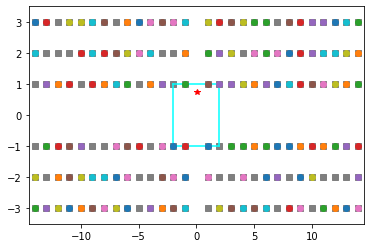

In [11]:
cm_x = round(barycenter_X.getValue(),2)
cm_y = round(barycenter_Y.getValue(),2)

print(f"Center of Mass: {(cm_x, cm_y)}")

#for p in range(passengers_count):
    #print(f"Satisfaction of {p}: {satisfaction[p].x}")

fig = plt.figure();
for seat in itertools.product(X,Y):
    if seat[0] != 0:
        plt.plot(seat[1],seat[0],'s', color="gray")

plt.plot([-bary_lim_Y, bary_lim_Y],  [bary_lim_X, bary_lim_X]  , color="cyan")
plt.plot([-bary_lim_Y, bary_lim_Y],  [-bary_lim_X, -bary_lim_X], color="cyan")
plt.plot([bary_lim_Y, bary_lim_Y],   [-bary_lim_X, bary_lim_X] , color="cyan")
plt.plot([-bary_lim_Y, -bary_lim_Y], [-bary_lim_X, bary_lim_X] ,  color="cyan")

#for g in range(len(groups)):
    #print(j_g_max[g].x, j_g_min[g].x)

for a in allocation:
    if allocation[a].x == 1:
        #random.seed(passengers[a[0]].group_index*4)
        colors = ["black", "blue", "yellow"]
        
        #plt.plot(X[a[1]],Y[a[2]], 'o',color=colors[passengers[a[0]].group_index-1])
        plt.plot(Y[a[2]],X[a[1]], 'o')
        #plt.text(Y[a[2]],X[a[1]],passengers[a[0]].group_index, ha="center", va="center")
        print(f"ID:{a[0]} - {(X[a[1]], Y[a[2]])}/{(a[1], a[2])} Sats: satisfaction[a[0]].x")
plt.plot(cm_x,cm_y, "*", color="red")
plt.xlim([-14.5,14.5])
plt.ylim([-3.5,3.5])

In [226]:
print(e_allocation(0,-1, 12))
print(e_allocation(0, 1, 12))
print(e_allocation(1,-1, 12))
print(e_allocation(1, 1, 12))
    
p = passengers[2]


for p_g in groups[p.group_index]:
    if True or p_g.passenger_id != p.passenger_id:
        s = sum([e_allocation(p.passenger_id,i,j) * (e_allocation(p_g.passenger_id,i-1,j)+e_allocation(p_g.passenger_id,i+1,j)) 
                for i in range(width+1) for j in range(height)])

        print(f"{p_g.passenger_id} {s.getValue()}")

0
<gurobi.Var Allocation[0,1,12] (value -0.0)>
0
<gurobi.Var Allocation[1,1,12] (value 0.0)>
1 1.0
2 1.0
3 0.0


In [182]:


#e_allocation = lambda p, i, j: allocation[p,i,j] if in_grid(i,j) else 0

m.addConstrs((satisfaction[p.passenger_id] == 
                sum([e_allocation(p.passenger_id,i,j) * (e_allocation(p_g.passenger_id,i-1,j)+e_allocation(p_g.passenger_id,i+1,j)) 
                for p_g in groups[p.group_index] for i in range(width+1) for j in range(height)])
                for p in passengers))


SyntaxError: closing parenthesis ')' does not match opening parenthesis '[' (<ipython-input-182-92d9fe606b56>, line 2)